In [1]:
import tensorflow as tf
from utils import custom_loss
from PIL import Image
import numpy as np
from utils import process_predictions

2022-09-30 10:36:05.607287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 10:36:05.748653: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 10:36:06.449785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-30 10:36:06.449838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
model = tf.keras.models.load_model('model', custom_objects = {"custom_loss": custom_loss})

2022-09-30 10:36:08.480529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 10:36:08.528383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-30 10:36:08.528406: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-30 10:36:08.528782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [32]:
import requests

In [44]:
url = "https://i.pinimg.com/736x/6a/21/76/6a2176a7899c185e2ba2be5ad79afae8.jpg"
r = requests.get(url, allow_redirects=True)

In [45]:
open('image.jpg', 'wb').write(r.content)

103105

In [3]:
image = Image.open("image.jpg")
image = image.resize((256,256))

In [4]:
import albumentations as albu

In [5]:
preprocess = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

In [6]:
image = np.array(image)
image = preprocess(image = image)
image = image['image']/255

In [9]:
image.shape

(256, 256, 3)

In [7]:
image = np.expand_dims(image, axis = 0)

In [38]:
image.shape

(1, 256, 256, 3)

In [8]:
from PIL import ImageDraw

In [9]:
pred = model.predict(image)

1/1 [==============================] - 0s 410ms/step


In [14]:
pred.shape

(1, 32, 32, 10)

In [10]:
def form_image_grid():    
    image_grid = np.zeros((32, 32, 4))

    # x, y, width, height
    cell = [0, 0, 256 / 32, 256 / 32] 

    for i in range(0, 32):
        for j in range(0, 32):
            image_grid[i,j] = cell

            cell[0] = cell[0] + cell[2]

        cell[0] = 0
        cell[1] = cell[1] + cell[3]

    return image_grid

In [13]:
form_image_grid().shape

(32, 32, 4)

In [11]:
pred = np.squeeze(pred)

In [12]:
pred.shape

(32, 32, 10)

In [13]:
pred = process_predictions(pred, form_image_grid())

(32, 32, 10)
(9, 4)


In [19]:
pred

array([[187.24847  , 132.83937  ,  16.39566  ,  16.578735 ],
       [181.69409  , 166.56775  ,  16.911545 ,  24.039658 ],
       [ 98.24001  , 126.813576 ,  20.609573 ,  13.460503 ],
       [178.00676  ,  82.85037  ,  22.745651 ,  21.070404 ],
       [ 47.225433 , 228.52861  ,  25.281204 ,  16.002548 ],
       [ 54.900078 ,  77.29363  ,  22.906555 ,  13.278488 ],
       [190.30487  ,  17.160034 ,  28.776215 ,  18.408852 ],
       [ 39.308746 , 205.50871  ,  14.024673 ,  16.26471  ],
       [ -4.820975 , 148.84286  ,  22.701353 ,  30.20517  ],
       [224.09671  , 215.34575  ,  24.240463 ,  21.212463 ],
       [  1.8942928,  76.54556  ,  13.602467 ,  17.376488 ],
       [ 61.146534 ,  57.13207  ,  32.885082 ,  19.67355  ],
       [240.96526  ,  95.602036 ,  16.726791 ,  24.249855 ],
       [ 17.873526 , 193.50996  ,  24.086374 ,  18.668655 ],
       [ 76.831764 , 229.93419  ,  29.2379   ,  15.71698  ],
       [ 13.789582 , 226.7313   ,  23.289688 ,  19.611053 ],
       [196.50172  ,  73

In [14]:
from matplotlib.pyplot import imshow

In [15]:
def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open(image_id)
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

In [16]:
drawn = draw_bboxes("image.jpg", bboxes = pred)

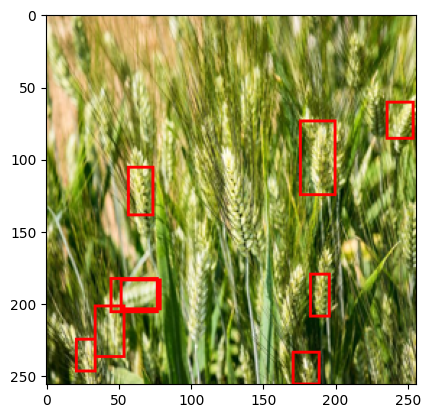

In [17]:
imshow(drawn)